# Preparing the financial data (news & market values)

In [1]:
from FinancialData import financial_data
iex = financial_data()
print(iex.get_trade_bars(['AAPL'], '1m')[:10])

   change  changeOverTime  changePercent   close        date     high   label  \
0    1.68        0.000000          0.899  188.47  2019-03-27  189.760  Mar 27   
1    0.25        0.001326          0.133  188.72  2019-03-28  189.559  Mar 28   
2    1.23        0.007853          0.652  189.95  2019-03-29  190.080  Mar 29   
3    1.29        0.014697          0.679  191.24  2019-04-01  191.680   Apr 1   
4    2.78        0.029448          1.454  194.02  2019-04-02  194.460   Apr 2   
5    1.33        0.036504          0.685  195.35  2019-04-03  196.500   Apr 3   
6    0.34        0.038308          0.174  195.69  2019-04-04  196.370   Apr 4   
7    1.31        0.045259          0.669  197.00  2019-04-05  197.100   Apr 5   
8    3.10        0.061707          1.574  200.10  2019-04-08  200.230   Apr 8   
9   -0.60        0.058524         -0.300  199.50  2019-04-09  202.850   Apr 9   

      low    open  unadjustedVolume    volume      vwap symbol  
0  186.55  188.75          29848427  298484

In [2]:
print(iex.get_news(['AAPL', 'MSFT'])[['symbol','time','headline']][:10])

  symbol                      time  \
0   AAPL 2019-04-27 09:12:19-04:00   
1   MSFT 2019-04-26 23:24:51-04:00   

                                            headline  
0  Stocks To Watch: Eyes On Apple, Uber, F8 And A...  
1  Azure And The Cloud Have Reinvigorated&#xA0;Mi...  


In [3]:
# list(iex.all_ticker()) : list off all valid securities' symbols
# This step could take a while, considering that this API provides 8750 security's related news
df = iex.get_news(list(iex.all_ticker()))
df.to_excel("assets/news.xlsx")

In [7]:
##### IOdy.py : ######
import pandas as pd
from datetime import datetime, timedelta
from pandas_datareader import data
import numpy as np

news = pd.read_excel('assets/news.xlsx', index_col=0)

#remove news that are published earlier than 30 days from today
absolute_thresh = pd.Timestamp(datetime.today().date()-timedelta(days=30))
news = pd.read_excel('assets/news.xlsx', index_col=0)
news = news.loc[news['time']>=absolute_thresh]
news[['symbol', 'time', 'headline', 'summary']].head()

,symbol,time,headline,summary
0,KAI,2019-04-04 16:25:54,12 Upcoming Dividend Increases,I'm a huge fan of dividend growth stocks an...
2,ALTM,2019-04-12 21:27:00,"FERC clears EPIC pipeline rates, three others ...",The 550K bbl/day EPIC pipeline wins appr...
3,ALTM,2019-03-31 20:26:45,Midstream Lollygags Into Quarter End,Stock prices across midstream were little c...
4,ALTM,2019-03-24 12:54:34,Midstream Marches Higher,The broad market crapped out Friday after r...
6,ATRI,2019-04-03 20:50:37,The Most Undervalued And Overvalued Dividend C...,"In June of 2015, I started a series of arti..."


In [16]:
# Extracting dates and creating consecutive time intervals
dates_ = []
for i in list(news.sort_values(by='time', ascending=True)['time']):
	tmp_ = i.date()
	if(tmp_ not in dates_):dates_.append(i.date())

intervals_ = [[dates_[i], dates_[i+1]] for i in range(len(dates_)-1)]

In [17]:
# This function uses Yahoo Finance to market data
def get_market(security, start_date, end_date):
	end_date_str = end_date.strftime("%Y-%m-%d")
	start_date_str = start_date.strftime("%Y-%m-%d")
	asset_ = data.DataReader(security,  start=start_date_str, end=end_date_str, data_source='yahoo')
	return asset_

get_market('AAPL', intervals_[0][0], intervals_[0][1])

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-03-21,196.330002,189.809998,190.020004,195.089996,51034200,195.089996
2019-03-22,197.690002,190.779999,195.339996,191.050003,42407700,191.050003


In [18]:
# Calculate the variation in a security price between start_date and end_date
market_resp = get_market('AAPL', intervals_[0][0], intervals_[0][1])
market_resp.pct_change()['Close'].values[-1]

-0.020708356973546005

In [3]:
import pandas as pd

# Joining the news with the associated market value (variation)
available_market = []
for j in intervals_:
    tmp_df = news.loc[(news['time']>=pd.Timestamp(j[0])) & (news['time']<pd.Timestamp(j[1]))].copy()
    for l in list(set(tmp_df['symbol'])):
        try:
            tmp_sum = ''.join(list(tmp_df.loc[(tmp_df['symbol']==l)]['summary']))
            tmp_sum = ' '.join(list(set(''.join(tmp_sum).split(' '))))
            market_resp = get_market(l, j[0], j[1])
            market_close = market_resp['Close'].values[-1]
            market_var = market_resp.pct_change()['Close'].values[-1]
            available_market.append(pd.DataFrame(np.array([[l, tmp_sum, pd.Timestamp(j[0]), market_close, market_var]]), index=range(1), columns=['symbol', 'summary', 'time' , 'Close' , 'Close_variation']))
        except Exception as e:
            print('[!] Error: ' + str(e))

tmp_pd = pd.concat(available_market)
tmp_pd.to_excel("assets/news_market.xlsx")
tmp_pd.head()[['symbol', 'summary', 'time', 'Close_variation']]

,symbol,summary,time,Close_variation
0,BHR,"BHR the Back h… year, in discount Resorts arg...",2019-03-19,0.038429
1,DMAC,DMAC Healthcare More … DiaMedica on: news sto...,2019-03-19,0.010638
2,CREE,Ga… the CREE in production like sales some ti...,2019-03-19,0.010475
3,KOPN,"announced KOPN), the wearable … stock. an sol...",2019-03-19,-0.008547
4,VTGN,this following deck published was more VistaG...,2019-03-19,-0.052632


# Clustering : Word dimensions (Sentiment & Distance)

In [9]:
####### NLP : Sentiment ###########

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
# Compound : aggregated score
print("Good Accuracy: %f"%sia.polarity_scores("good")['compound'])
print("Bad Accuracy: %f"%sia.polarity_scores("bad")['compound'])

Good Accuracy: 0.440400
Bad Accuracy: -0.542300


In [53]:
## For words that doesn't belong to the sentiment lexicon we use synonyms, antonyms 

import numpy as np
from nltk.corpus import wordnet

def approximate_sentiment(seq1, words_ref):
	global sia
	lexicon_, syn, ant = [0], [], []
	for l in range(2):
		for synset in wordnet.synsets(seq1):
			for lemma in synset.lemmas():
				syn.append(lemma.name())
				if lemma.antonyms():
					ant.append(lemma.antonyms()[0].name())
		tmp_corpus = []
		for i in syn:
			sent_ = sia.polarity_scores(i)['compound']
			if abs(sent_):
				tmp_corpus.append(sent_)
			if sum([1 for i in tmp_corpus if i>0])>len(tmp_corpus)/2:
				return np.mean([i for i in tmp_corpus if i>0])
			elif sum([1 for i in tmp_corpus if i<0])>len(tmp_corpus)/2:
				return np.mean([i for i in tmp_corpus if i<0])
		tmp_corpus = []
		for i in ant:
			sent_ = sia.polarity_scores(i)['compound']
			if abs(sent_):
				tmp_corpus.append(sent_)
			if sum([1 for i in tmp_corpus if i>0])>len(tmp_corpus)/2:
				return -1*np.mean([i for i in tmp_corpus if i>0])
			elif sum([1 for i in tmp_corpus if i<0])>len(tmp_corpus)/2:
				return -1*np.mean([i for i in tmp_corpus if i<0])
		for j in words_ref[:0]:
			if j[:2]=="un":
				j = j[:2]
			lexicon_.append(SequenceMatcher(None, seq1, j).ratio())
		if max(lexicon_)>=0.85:
			resp_ = words_ref[lexicon_.index(max(lexicon_))]
			if resp_[:2] in ["un", "in"]:
				seq1 = resp_
	return 0

### words_ref : list of words available in the sentiment lexicon ###
words_ref = list(sia.make_lex_dict().keys())
if "crooked" not in words_ref:
    print("[!] Approximated sentiment: %f"%float(approximate_sentiment("crooked", words_ref)))

[!] Approximated sentiment: -0.226300


In [59]:
# Distance metric : (this metric doesn't require two words to make comparison)
import string
def absolute_distance(seq1):
	seq1 = seq1.replace("-","")
	try:
		ref_ = np.array(range(1,10))
		spacial_seq = [string.ascii_lowercase.index(i) for i in (seq1+string.ascii_lowercase[:9])[:9]]
		return np.sum((np.array(spacial_seq)-np.array(ref_))**2)
	except Exception as e:
		return str(e)

print(absolute_distance("bright"))
print(absolute_distance("brighter"))
# Non-commutative
print(absolute_distance("brightre"))

574
598
624


In [76]:
# make a dataframe of words and their respective dimensions

def base_df(words_list):
	global sia
	distance_ = []
	vader_sentiment_ = []
	words_ref = list(sia.make_lex_dict().keys())
	for i in words_list:
		distance_.append(absolute_distance(i))
		sent_ = sia.polarity_scores(i)['compound']
		if not sent_:
			sent_ = approximate_sentiment(i, words_ref)
		vader_sentiment_.append(sent_)
	df = pd.DataFrame(np.array([distance_, vader_sentiment_]).transpose(), index=[i for i in words_list], columns=['distance','sentiment'])
	df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
	df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')
	df['distance'] /= df['distance'].max()
	return df.dropna(axis='rows')

with open("assets/50kenglish.txt", "r") as f:
	words_list = f.readlines()

words_list = [i.replace("\n","") for i in words_list]
df = base_df(words_list)
df.to_excel("assets/output.xlsx")
df.sample(10)

,distance,sentiment
detached,0.224004,-0.1280
caldera,0.204093,0.0000
uncritically,0.524336,0.0000
remaps,0.413717,0.0000
silting,0.443031,0.0000
stymied,0.685841,-0.4404
advantages,0.361173,0.3612
polluting,0.487832,-0.5106
guiltily,0.539823,-0.2732
darwin,0.405420,0.0000


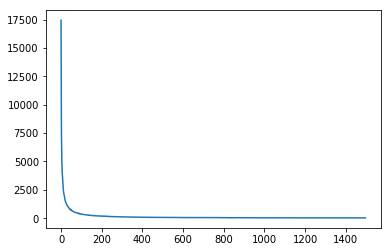

In [90]:
# determine optimal words clusters' number and their coordinates

from scipy.cluster.vq import kmeans
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

distorsions = []
scaler = StandardScaler()
X_std = scaler.fit_transform(df)
batch_ = 500
for k in range(2, (batch_*3)-1):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=batch_)
    kmeans.fit(X_std)
    distorsions.append(kmeans.inertia_)

with open("assets/distorsions.log", "w") as f:
    f.write(json.dumps(distorsions))


plt.plot(distorsions)
plt.show()

In [94]:
from scipy.cluster.vq import kmeans
from kneed import KneeLocator

kn = KneeLocator(range(2, (batch_*3)-1), distorsions, curve='convex', direction='decreasing')
print("Elbow's optimal clusters number: %d"%kn.knee)
features = np.c_[df]
clusters = kmeans(features,kn.knee)

with open("assets/englishClusters.log", "w") as f:
    f.write(json.dumps(clusters[0].tolist()))

Elbow's optimal clusters number: 228


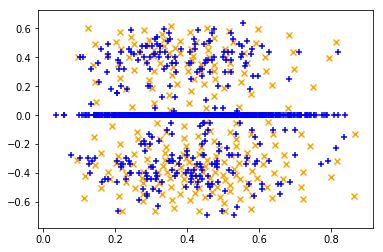

In [130]:
data = 0
with open("assets/englishClusters.log", "r") as f:
    data = json.loads(f.read())
    
plt.scatter([i[0] for i in data], [i[1] for i in data], marker='x', color="orange")
sample_w = df.sample(1000)
plt.scatter(sample_w['distance'], sample_w['sentiment'], marker='+', color="blue")

# Preparing the training and testing dataset

In [140]:
# SQLite queries handler:
import sqlite3
def sql_run(cmd):
	sql = sqlite3.connect("assets/test1.db")
	sql_cursor = sql.cursor()
	sql_cursor.execute(cmd)
	dbmsg = 0
	try:
		dbmsg = sql_cursor.fetchall()
	except:
		dbmsg = sql_cursor.fetchone()
	sql.commit()
	sql_cursor.close()
	sql.close()
	return dbmsg

In [135]:
# Store words in the DB, assign IDs and update words frequencies
def word_enumerate(words_list):
	sql_run('''CREATE TABLE IF NOT EXISTS words_register
			(word_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT, word text, count INTEGER);''')
	for word in words_list:
		select_ = sql_run('''SELECT word_id, count FROM words_register WHERE word="%s";'''%word)
		if len(select_):
			sql_run('''UPDATE words_register SET count=%d WHERE word_id=%d;'''%(select_[0][1]+1, select_[0][0]))
		else:
			sql_run('''INSERT INTO words_register (word, count) VALUES ('%s', 1);'''%word)


#Store news as a list of IDs (IDs are assigned by the previous function)
# argument is a python dictionnary: {0 : [time, [news summary as a list of words]}], 1: ...}
def news_storing(news_dic):
	sql_run('''CREATE TABLE IF NOT EXISTS news_register
			(news_id INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT, date text, summary_array text);''')
	news_idx = []
	for k in news_dic.keys():
		date = news_dic[k][0]
		words_list = tuple(news_dic[k][1])
		query = '''SELECT word_id, word FROM words_register WHERE word IN %s;'''%str(words_list)
		select_ = sql_run(query)
		numerical_equivalent = []
		for w in range(len(news_dic[k][1])):
			for j in select_:
				if j[1]==news_dic[k][1][w]:
					numerical_equivalent.append(j[0])
		sql_run('''INSERT INTO news_register (date, summary_array) VALUES ('%s', '%s');'''%(date, json.dumps(numerical_equivalent)))
		news_idx.append([words_list ,numerical_equivalent])
	return news_idx

In [137]:
# take the 8 least occuring words from each list of words (news)
# news_numeric is the a list of words associated IDs, that are equivalent to a news headline or summary
def freq_filter(news_numeric):
	query = '''SELECT word_id, word, count FROM words_register WHERE word_id IN %s;'''%str(tuple(news_numeric))
	select_ = sql_run(query)
	freq_ = [j[2] for j in select_]
	freq_ = sorted(list(set(freq_)), reverse=False)
	resp_ = []
	c = 0
	while len(resp_)<min(8, len(news_numeric)):
		for num in news_numeric:
			for j in select_:
				if j[0] == num and j[2] <= freq_[c]:
					resp_.append(num)
		c += 1
	resp_ += [0]*8
	return resp_[:8]

In [138]:
# Assign each word to the closest cluster centroid coordinates
def assignment(df, centroids):
	for i in range(len(centroids)):
		df['distance_from_{}'.format(i)] = (
			np.sqrt(
				(df['distance'] - centroids[i][0]) ** 2
				+ (df['sentiment'] - centroids[i][1]) ** 2
			)
		)
	centroid_distance_cols = ['distance_from_{}'.format(i) for i in range(len(centroids))]
	df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
	df['kmean'] = df['closest'].apply(lambda x: str(x).replace('distance_from_',''))
	df['kmean'] = pd.to_numeric(df['kmean'])
	df['cluster_distance'] = df['kmean'].map(lambda x: centroids[x][0])
	df['cluster_sentiment'] = df['kmean'].map(lambda x: centroids[x][1])
	return df

# The final step in preparing the training dataset using all the function defined above

In [143]:
#The following functions will use the previous functions to make the final training dataset, by joining different types of outputs (words_ids, dimensions, assigned clusters ...)

def prelayer_processor(news_df):
	sia = SentimentIntensityAnalyzer()
	conca_, filtred_news = [], []
	news_df = news_df[['summary', 'time', 'symbol']]
	news_dic = {}
	for i in news_df.index:
		tmp_iloc = news_df.iloc[i]
		conca_ += tmp_iloc['summary']
		news_dic[i] = [tmp_iloc['time'], tmp_iloc['summary']]
	word_enumerate(conca_)
	news_idx = news_storing(news_dic)
	words_idx = []
	for article in range(len(news_idx)):
		tmp_ = freq_filter(news_idx[article][1])
		words_idx += tmp_
		tmp_word = []
		for i in tmp_:
			tmp_word.append(news_idx[article][0][news_idx[article][1].index(i)])
		news_idx[article][1] = tmp_word
		filtred_news.append(tmp_word)
	conca_sep = []
	for i in news_idx:
		conca_sep.append(list(i[1]))
	vader_sentiment_, distance_ = [], []
	conca_ = sum(conca_sep, [])
	words_ref = list(sia.make_lex_dict().keys())
	for i in conca_:
		distance_.append(absolute_distance(i))
		sent_ = sia.polarity_scores(i)['compound']
		if not sent_:
			sent_ = approximate_sentiment(i, words_ref, sia)
		vader_sentiment_.append(sent_)
	words_position = np.asarray(sum([[round((j+1)/len(i), 4) for j in range(len(i))] for i in conca_sep], []), dtype='float64')
	symbols = sum([[i]*8 for i in list(news_df['symbol'])], [])
	df = pd.DataFrame(np.array([distance_, vader_sentiment_, words_position, words_idx, symbols]).transpose(), index=[i for i in conca_], columns=['distance','sentiment', 'position', 'word_id', 'symbol'])
	df['distance'] = pd.to_numeric(df['distance'], errors='coerce')
	df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')
	df['position'] = pd.to_numeric(df['position'], errors='coerce')
	df['word_id'] = pd.to_numeric(df['word_id'], errors='coerce')
	for col in list(df.columns)[:-1]:
		c_ = df[col]
		df[col] = (c_ - c_.mean())/c_.std(ddof=0)
	df = df.dropna(axis='rows')
	clusters = []
	with open("assets/englishClusters.log", "r") as f:
		clusters = json.loads(f.read())
	df = assignment(df, clusters)[['distance', 'sentiment', 'position', 'kmean', 'cluster_distance', 'cluster_sentiment', 'word_id', 'symbol']].dropna(axis='rows')
	return df.dropna(axis='rows'), filtred_news


#process_IODF: join multiple news, published within small time frame related to the same security
#and provide the associated market trend
def process_IODF():
	data = pd.read_excel("assets/dataset_news_market.xlsx", index_col=0)
	data.index = pd.RangeIndex(len(data))
	from nltk.tokenize import TreebankWordTokenizer
	tokenizer = TreebankWordTokenizer()
	for k in range(data.index[-1]+1):
		tmp_s = data.iloc[k]['summary'].lower()
		tmp_s = ''.join([i for i in tmp_s if i in string.ascii_lowercase+" "])
		tmp_s = tokenizer.tokenize(tmp_s)
		if len(tmp_s) < 8:
			data.at[k, 'summary'] = float('NaN')
		else:
			data.at[k, 'summary'] = tmp_s
	return data


#Join input(prelayer_processor) and output(market_trend)
def neural_dataframe():
	info = process_IODF().dropna(axis='rows')
	info.index = pd.RangeIndex(len(info))
	alpha_df, filtred_news = prelayer_processor(info)
	assign = []
	for j in range(0, len(alpha_df), 8):
		input_ = []
		for i in range(8):
			#the linear formula to convert each word : (3*word_sentiment+cluster_distance+2*word_position)/6
			input_.append((3*alpha_df.iloc[i+j].sentiment+alpha_df.iloc[i+j].cluster_distance+2*alpha_df.iloc[i+j].position)/6)
		assign.append([alpha_df.iloc[j].symbol, input_, info.iloc[int(j/8)]['Close_variation']])
	df = pd.DataFrame(np.array(assign), columns=['symbol', 'input', 'output'])
	expand_df = df['input'].apply(pd.Series)
	expand_df = expand_df.rename(columns = lambda x : 'word_' + str(x))
	assign = pd.concat([df['symbol'], expand_df[:], df['output']], axis=1)
	assign = assign.loc[assign['output']!=0].copy()
	return assign

final_df = neural_dataframe()
final_df.to_excel("assets/neural_training_dataset.xlsx")
final_df.head()

,symbol,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,output
0,BHR,-1.686418,-0.305010,-0.211008,-0.073558,0.088254,-0.959025,0.422383,0.516385,0.038429
1,DMAC,-0.509994,-0.364515,-0.219037,-0.073558,-0.438831,0.217399,0.362877,-0.002395,0.010638
2,CREE,-0.509994,-0.290861,-0.219037,-0.073558,0.071920,0.217399,-1.487436,0.582010,0.010475
3,KOPN,-0.501965,-0.356486,-0.211008,0.000096,0.079949,0.225428,0.400047,0.582010,-0.008547
4,VTGN,-0.381409,0.400173,-0.090452,0.691130,0.200505,0.225428,1.127566,0.636941,-0.052632


# Deep learning using Tensorflow:

In [146]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from scipy import stats
import os
#Supress debugging info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

df = pd.read_excel("assets/neural_training_dataset.xlsx", index_col=0)
df = df.drop(['symbol'],axis=1)
# Remove rows where predictions are too close to 0
df = df.loc[(np.abs(stats.zscore(df['output'])) > 0.5)].copy()

df_train = df[:2000]
df_test = df[2000:2500]


X_train = df_train.drop(['output'],axis=1).values
y_train = df_train['output'].values.reshape(-1, 1)
X_test = df_test.drop(['output'],axis=1).values
y_test = df_test['output'].values.reshape(-1, 1)

#Define the network structure and the activation function
def neural_net_model(X_data,input_dim):
	W_1 = tf.Variable(tf.random_uniform([input_dim,24],maxval=0.3))
	b_1 = tf.Variable(tf.zeros([24]))
	layer_1 = tf.add(tf.matmul(X_data,W_1), b_1)
	layer_1 = tf.nn.sigmoid(layer_1)

	W_2 = tf.Variable(tf.random_uniform([24,24],maxval=0.3))
	b_2 = tf.Variable(tf.zeros([24]))
	layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
	layer_2 = tf.nn.sigmoid(layer_2)

	W_3 = tf.Variable(tf.random_uniform([24,24],maxval=0.3))
	b_3 = tf.Variable(tf.zeros([24]))
	layer_3 = tf.add(tf.matmul(layer_2,W_3), b_3)
	layer_3 = tf.nn.sigmoid(layer_3)

	W_O = tf.Variable(tf.random_uniform([24,1],maxval=0.3))
	b_O = tf.Variable(tf.zeros([1]))
	output = tf.add(tf.matmul(layer_3,W_O), b_O)
	return output,W_O


xs = tf.placeholder("float")
ys = tf.placeholder("float")


output,W_O = neural_net_model(xs,8)

cost = tf.reduce_mean(tf.square(output-ys))
#1e-4 is the optimazer learning rate
train = tf.train.AdamOptimizer(1e-4).minimize(cost)

correct_pred = tf.argmax(output, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

c_t = []
c_test = []

Cost : 0.0056045623


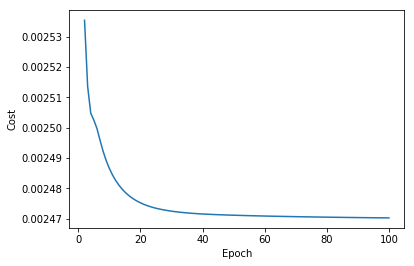

In [180]:
#Start a training and testing session:
import time, codecs

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
with tf.Session() as sess:
	time.sleep(5)
	sess.run(tf.initialize_all_variables())
	saver = tf.train.Saver()
	y_t = y_train
	record_cost = []
	for i in range(100):
		for j in range(X_train.shape[0]):
			sess.run([cost,train],feed_dict={xs:X_train[j,:].reshape(1,8), ys:y_train[j]})
		pred = sess.run(output, feed_dict={xs:X_train})
		c_t.append(sess.run(cost, feed_dict={xs:X_train,ys:y_train}))
		c_test.append(sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
		record_cost.append(c_t[i])

	pred = sess.run(output, feed_dict={xs:X_test})
	print('Cost :',sess.run(cost, feed_dict={xs:X_test,ys:y_test}))
	a = np.array([y_test, pred]).reshape(-1,y_test.shape[0]).transpose()
	b = a.tolist()
	file_path = "assets/result.json"
	json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4)
	plt.plot(range(2, len(record_cost)+1), record_cost[1:])
	plt.xlabel('Epoch')
	plt.ylabel('Cost')
	plt.show()

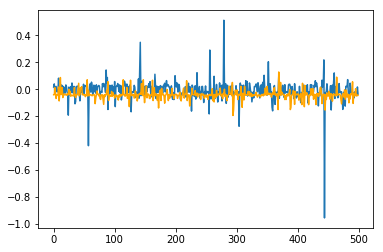

In [183]:
# Plot amplified prediction and the original market values
	plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
	plt.plot(range(y_test.shape[0]),pred*30,label="Predicted Data",color='orange')
	plt.show()

# Evaluating the predictions accuracy :

In [192]:
obj_text = codecs.open('assets/result.json', 'r', encoding='utf-8').read()
obj_np = np.array(json.loads(obj_text))
for j in [[0, 'Unfiltred'], [int(len(obj_np)/2), 'Filtered']]:
    print("[!] Apply: "+j[1])
    res = pd.DataFrame(obj_np, columns=['original','predict'])[j[0]:]
    thresh_ = res['predict'].value_counts().median()
    for i in range(len(res['predict'].value_counts())):
        if res['predict'].value_counts().iloc[i] <= thresh_:
            thresh_ = i
            break
    res = res.loc[res['predict'].isin(res['predict'].value_counts().index[thresh_:])].copy()
    print("Accuracy : {0:.2f}%".format(res.loc[res['original']*res['predict']>0].shape[0]*100/res.shape[0]))

[!] Apply: Unfiltred
Accuracy : 55.99%
[!] Apply: Filtered
Accuracy : 63.92%
